# SF2980 Risk Management — Project 1A, Group 25


### Use of Generative AI

Portions of this project were supported by the use of OpenAI's ChatGPT (GPT-5, 2025).  
The tool was used to:
- Creating Latex equations and refining markdown explanations.
- Debug Python code related to the computation of empirical and true VaR values and bootstrap resampling.

All statistical reasoning, implementation details, and final results were implemented independently from AI use.
The code and interpretations presented here reflect our own original work.
Find specific prompts use to generate code in ./ai_use_log.txt

In [49]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

### A.1(a) — Exact Confidence Interval for $F^{-1}(0.975)$

We draw a sample of size $n = 700$ from the distribution 
$t_5(\mu = 1, \sigma = 0.01)$.

Following Section 7.5.1 *“Exact Confidence Intervals for Quantiles”* in **Hult et al. (2013)**, 
an exact $(1 - \alpha)$ confidence interval for the quantile $F^{-1}(p)$ is constructed using
the order statistics of the sample. The interval is given by

$$
[X_{(L)}, X_{(U)}],
$$

where $X_{(L)}$ and $X_{(U)}$ denote the $L$th and $U$th order statistics, respectively.
The ranks $L$ and $U$ are determined using the binomial probabilities associated with 
$Y_{F^{-1}(p)} \sim \text{Binomial}(n, p)$ so that the coverage probability is approximately $1 - \alpha$.

For this problem, we use $p = 0.975$, $\alpha = 0.05$, and $n = 700$.
The resulting interval $[X_{(L)}, X_{(U)}]$ provides an exact 95% confidence interval for the 97.5% quantile.

In [50]:
# parameters
nu, mu, sigma = 5, 1.0, 0.01
n = 700    # sample size
p = 0.975
alpha = 0.05
rng = np.random.default_rng(123)

# 1) sample
sample = mu + sigma * stats.t.rvs(df=nu, size=n, random_state=rng)

# 2) order stats
xs = np.sort(sample)

# 3) compute ranks L, U using Binomial(n, p)
def exact_quantile_rank_bounds(n, p, alpha=0.05):
    
    # smallest k with CDF(k-1; n, p) ≥ alpha/2
    L = int(stats.binom.ppf(alpha/2, n, p)) + 1
    
    # smallest k with CDF(k-1; n, p) ≥ 1 - alpha/2
    U = int(stats.binom.ppf(1 - alpha/2, n, p)) + 1
    
    return L, U

L, U = exact_quantile_rank_bounds(n, p, alpha)

# 4) CI
ci_low = xs[max(L-1, 0)]
ci_high = xs[min(U-1, n-1)]

(ci_low, ci_high, (L, U))

(np.float64(1.0229739846389831), np.float64(1.0339256147994418), (675, 691))

### A.1(b) — Repeated Sampling and Coverage Verification

Following *Example 7.10* in **Hult et al. (2013)**, we repeat the procedure from (a)
$k = 200$ times, each time drawing a new sample of size $n = 500$ from 
$t_5(\mu = 1, \sigma = 0.01)$.

For each replication, we construct an exact 95 % confidence interval for 
the 97.5 % quantile $F^{-1}(0.975)$ using the method from Section 7.5.1.
We then check whether the true quantile

$$
q_{\text{true}} = \mu + \sigma\,t^{-1}_{5}(0.975)
$$

is contained within the interval.

By repeating the experiment many times, we can **empirically estimate the coverage probability**,
that is, the proportion of intervals that actually contain the true quantile.
If the exact method is correctly implemented, this proportion should be close to 0.95,
confirming the theoretical coverage derived in the book.

In [51]:
k = 200     # number of replications
n = 500     # sample size

# True target quantile (for evaluation only)
q_true = mu + sigma * stats.t.ppf(p, df=nu)
L, U = exact_quantile_rank_bounds(n, p, alpha)

# Run k replications
intervals = np.empty((k, 2))
for i in range(k):
    samp = mu + sigma * stats.t.rvs(df=nu, size=n, random_state=rng)
    xs = np.sort(samp)
    low = xs[max(L-1, 0)]
    high = xs[min(U-1, n-1)]
    intervals[i, 0] = low
    intervals[i, 1] = high

# Coverage and some diagnostics
covered = (intervals[:, 0] <= q_true) & (q_true <= intervals[:, 1])
coverage = covered.mean()

# Optional: interval widths
widths = intervals[:, 1] - intervals[:, 0]
width_summary = (float(widths.min()), float(np.median(widths)), float(widths.max()))

print(f"Out of {k} simulated intervals, {covered.sum()} contained the true quantile.")
print(f"Empirical coverage: {coverage:.3f} (expect 0.95)")
print(f"Interval width: {width_summary[0]:.5f}, {width_summary[1]:.5f}, {width_summary[2]:.5f}")

Out of 200 simulated intervals, 191 contained the true quantile.
Empirical coverage: 0.955 (expect 0.95)
Interval width: 0.00529, 0.00999, 0.02600


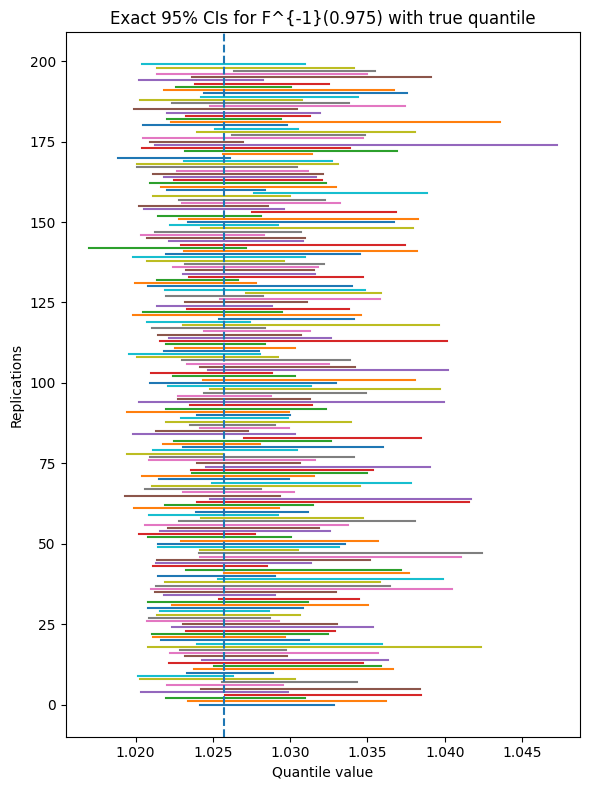

In [52]:
plt.figure(figsize=(6, 8))
for i, (low, high) in enumerate(intervals):
    plt.plot([low, high], [i, i])
plt.axvline(q_true, linestyle='--')
plt.xlabel('Quantile value')
plt.ylabel('Replications')
plt.title('Exact 95% CIs for F^{-1}(0.975) with true quantile')
plt.tight_layout()
plt.show()

### A.2(a) — True $\theta$ and Monte Carlo error of $\hat\theta$

The task is to compute the true $\theta = \mathrm{VaR}_{0.025}(X)$ under the model 
$R_1 \sim t_5(\mu=1, \sigma=0.01)$ with $V_0 = 10$, and to evaluate how the empirical estimator 
$\hat\theta$ behaves when estimated repeatedly from finite samples.

Following **Hult et al. (2013, Sec. 7.5.2, Ex. 7.11)**, the VaR for the profit/loss 
$X = V_1 - V_0$ is expressed through the loss $L = V_0 - V_1 = V_0(1 - R_1)$.  
From the book, VaR for $X$ can be written in terms of the $t$-quantile of the return distribution:
$$
\theta = V_0 \big(1 - F^{-1}_{R_1}(0.025)\big),
$$
which gives a closed-form value via the inverse $t_5$-quantile.  

**Steps:**
- The analytical (true) $\theta$ is computed directly from this expression.  
- To study estimation uncertainty, $N=1000$ Monte Carlo replications are performed, each drawing 
   $n=100$ i.i.d. samples of $R_1$ and computing an empirical VaR from the corresponding loss values.  
- The sampling error is visualized by plotting the histogram of 
   $\theta - \hat\theta$, which should be approximately centered around zero if the 
   estimator is unbiased.

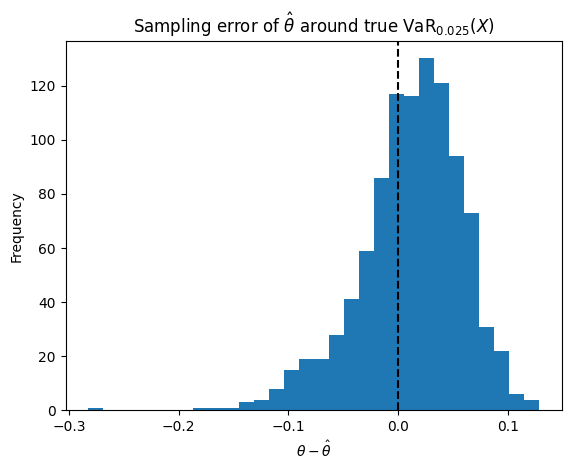

In [53]:
def VaR_loss(L, alpha, method="linear"):
    """
    Empirical VaR_alpha computed on a loss sample L = V0 - V1.
    Returns the (1 - alpha)-quantile of losses (right-tail VaR).
    """
    return np.quantile(L, 1 - alpha, method=method)

def true_VaR(mu, sigma, df, alpha, V0):
    """
    True VaR for X = V0*(R - 1) with R ~ t_df(mu, sigma), per Hult et al., Ex. 7.11:
    VaR_alpha(X) = V0 * (1 - F_R^{-1}(alpha)).
    """
    r_alpha = mu + sigma * stats.t.ppf(alpha, df=df)
    return V0 * (1 - r_alpha)

nu, mu, sigma = 5, 1.0, 0.01
V0, alpha, N, n = 10, 0.025, 1000, 100
rng = np.random.default_rng(123)

theta_true = true_VaR(mu, sigma, nu, alpha, V0)

theta_hats = np.empty(N)
for j in range(N):
    R = mu + sigma * stats.t.rvs(df=nu, size=n, random_state=rng)
    L = V0 * (1 - R)                   # loss sample
    theta_hats[j] = VaR_loss(L, alpha) # right-tail on loss

diffs = theta_true - theta_hats

plt.hist(diffs, bins=30)
plt.axvline(0, color='k', linestyle='--')
plt.title("Sampling error of $\\hat{\\theta}$ around true VaR$_{0.025}(X)$")
plt.xlabel("$\\theta - \\hat{\\theta}$")
plt.ylabel("Frequency")
plt.show()

### A.2(b) — Bootstrap distribution of $\hat\theta$ from a historical window

We now treat one length-$n$ “historical” sample as fixed and use the **nonparametric bootstrap**
(Chapter 7) to approximate the sampling distribution of the VaR estimator without assuming a parametric $F$.
Following **Ex. 7.11**, we estimate VaR from **losses** $L=V_0(1-R)$.

**Steps**:
- Draw $B$ bootstrap resamples (with replacement) of size $n$ from the historical loss sample.
- For each resample, compute $\hat\theta^{*}$ (empirical VaR of the resampled losses).
- Summarize $\{\hat\theta^{*}_b\}_{b=1}^B$ by bias, standard error, and the **percentile bootstrap CI**
$[\hat\theta^{*}_{(2.5\%)},\,\hat\theta^{*}_{(97.5\%)}]$.
- Plot the histogram of $\hat\theta_{\text{obs}}-\hat\theta^{*}$.

This implements the book’s bootstrap logic (Ch. 7) while keeping the VaR definition consistent with Ex. 7.11.


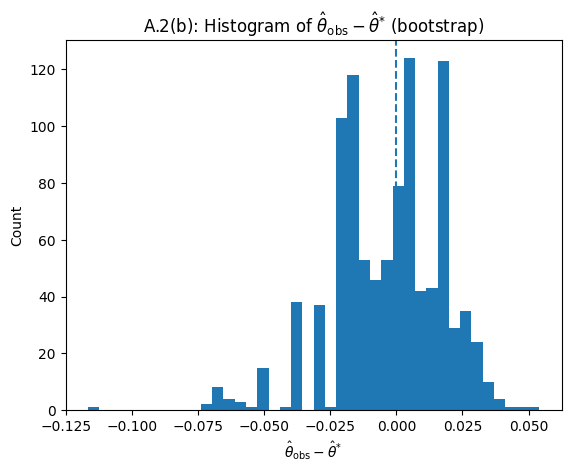

θ̂_obs = 0.252379 | bias≈ 0.002854, SE≈ 0.020671 | Percentile CI: [0.220889, 0.302339] | 


In [ ]:
n_hist, B = 700, 1000   # historical sample size, bootstrap replicates

# 1) Generate historical sample
R_hist = mu + sigma * stats.t.rvs(df=nu, size=n_hist, random_state=rng)
L_hist = V0 * (1 - R_hist)
theta_obs = VaR_loss(L_hist, alpha)  # VaR from the historical sample

# 2) Bootstrap resampling of the historical losses
idx = rng.integers(0, n_hist, size=(B, n_hist))      # bootstrap indices
L_boot = L_hist[idx]
theta_star = np.quantile(L_boot, 1 - alpha, axis=1, method="linear")

# 3) Bootstrap summaries (percentile CI, bias, SE)
ci_pct = (float(np.quantile(theta_star, 0.025)),
          float(np.quantile(theta_star, 0.975)))
bias   = float(theta_star.mean() - theta_obs)
se     = float(theta_star.std(ddof=1))

# 4) Plot histogram of (theta_obs - theta_star)
plt.figure()
plt.hist(theta_obs - theta_star, bins=40)
plt.axvline(0, linestyle="--")
plt.title(r"A.2(b): Histogram of $\hat{\theta}_{\rm obs} - \hat{\theta}^{*}$ (bootstrap)")
plt.xlabel(r"$\hat{\theta}_{\rm obs} - \hat{\theta}^{*}$")
plt.ylabel("Count")
plt.show()

# 5) Verification step: print results
print(f"θ̂_obs = {theta_obs:.6f} | bias≈ {bias:.6f}, SE≈ {se:.6f} | "
      f"Percentile CI: [{ci_pct[0]:.6f}, {ci_pct[1]:.6f}] | ")

### A.2(c)